In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
!pip install pydot graphviz
!apt-get install graphviz
!pip install pydot

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


In [2]:
from PIL import Image
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import tensorflow as tf
import datetime
import cv2
import tensorflow as tf
from IPython.display import clear_output
from skimage.metrics import structural_similarity as ssim

In [3]:
# Preprocessing function
def preprocess_image(img, size):
    # Resize
    img = img.resize(size)

    # Convert to NumPy array
    img_np = np.array(img)

    # Histogram Equalization (per channel if RGB)
    if len(img_np.shape) == 3 and img_np.shape[2] == 3:
        img_yuv = cv2.cvtColor(img_np, cv2.COLOR_RGB2YUV)
        img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
        img_np = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)

    # Noise Reduction
    img_np = cv2.GaussianBlur(img_np, (3, 3), 0)

    # Normalize to [-1, 1]
    img_np = img_np.astype(np.float32)
    img_np = (img_np / 127.5) - 1

    return img_np

# Paths for training
input_train_dir = "/content/drive/MyDrive/ImageEnhancement/Data/train/input"
target_train_dir =  "/content/drive/MyDrive/ImageEnhancement/Data/train/target"

# Initialize lists
X_train = []
Y_train = []

# Set size for training data
train_data_size = 1000

# File lists
input_train_filenames = sorted(os.listdir(input_train_dir))
target_train_filenames = sorted(os.listdir(target_train_dir))

# Load and preprocess training images (up to 1000 images)
for i in tqdm(range(min(len(input_train_filenames), train_data_size))):
    input_path = os.path.join(input_train_dir, input_train_filenames[i])
    target_path = os.path.join(target_train_dir, target_train_filenames[i])

    try:
        input_img = Image.open(input_path).convert("RGB")
        target_img = Image.open(target_path).convert("RGB")

        # Apply preprocessing
        input_processed = preprocess_image(input_img, (256, 256))  # ✅ Desired
        target_processed = preprocess_image(target_img, (256, 256))

        X_train.append(input_processed)
        Y_train.append(target_processed)

    except Exception as e:
        print(f"Error with image {input_train_filenames[i]}: {e}")

# Convert to numpy arrays
X_train = np.array(X_train)
Y_train = np.array(Y_train)

print("X_train:", X_train.shape)
print("Y_train:", Y_train.shape)


100%|██████████| 1000/1000 [07:58<00:00,  2.09it/s]


X_train: (1000, 256, 256, 3)
Y_train: (1000, 256, 256, 3)


In [6]:
# Downsampling block
# Structure: Conv2D -> BatchNorm -> LeakyReLU
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.keras.initializers.HeNormal()

    result = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                               kernel_initializer=initializer, use_bias=False)
    ])

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU(negative_slope=0.2))  # Updated parameter name

    return result

# Upsampling block
# Structure: Conv2DTranspose -> BatchNorm -> Dropout -> ReLU
def upsample(filters, size, apply_dropout=False):
    initializer = tf.keras.initializers.HeNormal()

    result = tf.keras.Sequential([
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                        kernel_initializer=initializer, use_bias=False),
        tf.keras.layers.BatchNormalization()
    ])

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result


In [7]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])  # Input shape is now 256x256x3

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (bs, 128, 128, 64)
        downsample(128, 4),  # (bs, 64, 64, 128)
        downsample(256, 4),  # (bs, 32, 32, 256)
        downsample(512, 4),  # (bs, 16, 16, 512)
        downsample(512, 4),  # (bs, 8, 8, 512)
        downsample(512, 4),  # (bs, 4, 4, 512)
        downsample(512, 4),  # (bs, 2, 2, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (bs, 4, 4, 512)
        upsample(512, 4, apply_dropout=True),  # (bs, 8, 8, 512)
        upsample(512, 4, apply_dropout=True),  # (bs, 16, 16, 512)
        upsample(512, 4),  # (bs, 32, 32, 512)
        upsample(256, 4),  # (bs, 64, 64, 256)
        upsample(128, 4),  # (bs, 128, 128, 128)
        upsample(64, 4),  # (bs, 256, 256, 64)
    ]

    initializer = tf.random_normal_initializer(0.0, 0.02)
    last = tf.keras.layers.Conv2DTranspose(3, 4, strides=2, padding='same',
                                           kernel_initializer=initializer, activation='tanh')

    x = inputs
    skips = []

    # Downsampling part
    for down in down_stack:
        x = down(x)
        skips.append(x)

    # Reverse skips for correct concatenation during upsampling
    skips = reversed(skips[:-1])

    # Upsampling part
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])  # Concatenate skip connections

    # Final layer
    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)


In [8]:
generator = Generator()
generator.summary()


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128, 128,  │      3,072 │ input_layer[0][0] │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 64, 64,    │    131,584 │ sequential[0][0]  │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 32, 32,    │    525,312 │ sequential_1[0][… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 16, 16,    │  2,099,200 │ sequential_2[0][… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 8, 8, 512) │  4,196,352 │ sequential_3[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 4, 4, 512) │  4,196,352 │ sequential_4[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 2, 2, 512) │  4,196,352 │ sequential_5[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 4, 4, 512) │  4,196,352 │ sequential_6[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 4, 4,      │          0 │ sequential_7[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, 8, 8, 512) │  8,390,656 │ concatenate[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 8, 8,      │          0 │ sequential_8[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_9        │ (None, 16, 16,    │  8,390,656 │ concatenate_1[0]… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 16, 16,    │          0 │ sequential_9[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_10       │ (None, 32, 32,    │  8,390,656 │ concatenate_2[0]… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 32, 32,    │          0 │ sequential_10[0]… │
│ (Concatenate)       │ 768)              │            │ sequential_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_11       │ (None, 64, 64,    │  3,146,752 │ concatenate_3[0]

 Total params: 48,659,459 (185.62 MB)

 Trainable params: 48,649,731 (185.58 MB)

 Non-trainable params: 9,728 (38.00 KB)

In [ ]:
LAMBDA = 500
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
    # Adversarial Loss (GAN Loss)
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # L1 Loss (Content Loss) - measures absolute difference between generated and target images
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    # Total Generator Loss - weighted combination of adversarial and content loss
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss


In [ ]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')  # Input size changed to 256x256
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    # If inp and tar are already 256x256, no need to resize
    # inp_resized = tf.keras.layers.Lambda(lambda x: tf.image.resize(x, (256,256), method='bicubic'))(inp)  # Removed resizing

    x = tf.keras.layers.concatenate([inp, tar])  # (bs,256,256,6)
    x = downsample(64, 4, apply_batchnorm=False)(x)  # (bs,128,128,64)
    x = downsample(128, 4)(x)  # (bs,64,64,128)
    x = downsample(256, 4)(x)  # (bs,32,32,256)

    x = tf.keras.layers.ZeroPadding2D()(x)  # (bs,34,34,256)
    x = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(x)  # (bs,31,31,512)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)

    x = tf.keras.layers.ZeroPadding2D()(x)  # (bs,33,33,512)
    x = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(x)  # (bs,30,30,1)

    return tf.keras.Model(inputs=[inp, tar], outputs=x)


In [ ]:
# Test the discriminator model
discriminator = Discriminator()
discriminator.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ target_image        │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 256, 256,  │          0 │ input_image[0][0… │
│ (Concatenate)       │ 6)                │            │ target_image[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_14       │ (None, 128, 128,  │      6,144 │ concatenate_6[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_15       │ (None, 64, 64,    │    131,584 │ sequential_14[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_16       │ (None, 32, 32,    │    525,312 │ sequential_15[0]… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 34, 34,    │          0 │ sequential_16[0]… │
│ (ZeroPadding2D)     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 31, 31,    │  2,097,152 │ zero_padding2d[0… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 31,    │      2,048 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_10      │ (None, 31, 31,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 33, 33,    │          0 │ leaky_re_lu_10[0… │
│ (ZeroPadding2D)     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 30, 30, 1) │      8,193 │ zero_padding2d_1… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,770,433 (10.57 MB)

 Trainable params: 2,768,641 (10.56 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [ ]:
def discriminator_loss(disc_real_output, disc_gen_output):
    # Loss for real images: We want discriminator to output 1 for real images
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    # Loss for generated images: We want discriminator to output 0 for fake images
    gen_loss = loss_object(tf.zeros_like(disc_gen_output), disc_gen_output)

    # Total loss is the sum of real and generated losses
    total_loss = real_loss + gen_loss

    return total_loss


In [ ]:
# Ensure checkpoint directory exists
checkpoint_dir = "./training_checkpoints"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Checkpointing
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Saving checkpoint after every epoch
def save_checkpoint(epoch):
    checkpoint.save(file_prefix=checkpoint_prefix + f"_epoch_{epoch}")

# Restoring the most recent checkpoint
def restore_checkpoint():
    latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
    if latest_checkpoint:
        checkpoint.restore(latest_checkpoint)
        print(f"Restored from {latest_checkpoint}")
    else:
        print("No checkpoint found, starting from scratch.")


In [ ]:
def generate_images(model, inp, tar, resize_dim=(200, 200)):
    """
    Generate and display images (input, prediction, and target).

    Args:
        model: The trained generator model.
        inp: The input image(s).
        tar: The target image(s).
        resize_dim: Tuple for the desired output size of the prediction (default: (200, 200)).
    """
    # Normalize input for the model (-1 to 1 range)
    inp_normalized = (inp / 127.5) - 1

    # Generate prediction
    pred = model(inp_normalized, training=True)
    pred = (pred + 1) * 127.5  # Convert back to 0-255 range
    pred = np.array(pred[0], dtype='uint8')  # Convert to uint8 format

    # Resize prediction (if needed)
    pred_resized = Image.fromarray(pred, 'RGB').resize(resize_dim)
    pred_resized = np.array(pred_resized).reshape((1, resize_dim[0], resize_dim[1], 3))

    # Prepare images for display
    display_list = [
        np.array(inp[0], dtype='uint8'),
        np.array(pred_resized[0], dtype='uint8'),
        np.array(tar[0], dtype='uint8')
    ]
    title_list = ['Input', 'Prediction', 'Target']

    # Plot the images
    plt.figure(figsize=(20, 20))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(title_list[i])
        plt.imshow(display_list[i])
        plt.axis('off')

    plt.show()

    # Optionally return the prediction if needed
    return pred_resized


In [ ]:
@tf.function
def train_step(inp, tar):
    # Ensure that inp and tar are batched correctly
    inp = tf.expand_dims(inp, axis=0)  # Shape becomes (1, 256, 256, 3)
    tar = tf.expand_dims(tar, axis=0)  # Shape becomes (1, 256, 256, 3)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate output from the generator
        gen_output = generator(inp, training=True)

        # Ensure generator output matches the target size (256x256)
        gen_output_resized = tf.image.resize(gen_output, (256, 256))

        # Discriminator output
        disc_real_output = discriminator([inp, tar], training=True)
        disc_gen_output = discriminator([inp, gen_output_resized], training=True)

        # Compute generator and discriminator losses
        gen_loss = generator_loss(disc_gen_output, gen_output_resized, tar)
        disc_loss = discriminator_loss(disc_real_output, disc_gen_output)

    # Compute gradients and apply them to the respective optimizers
    gen_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_grads = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply the gradients
    generator_optimizer.apply_gradients(zip(gen_grads, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(disc_grads, discriminator.trainable_variables))


In [ ]:
def fit(X_train, Y_train, X_test, Y_test, epochs):
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        # Training loop for each batch in the training set
        for inp, tar in tqdm(zip(X_train, Y_train), total=len(X_train)):
            train_step(inp, tar)

        # Optionally: Add evaluation of model performance on test data (for monitoring)
        # Here you can evaluate your model and print PSNR/SSIM scores for example
        # If you are not performing evaluation here, just remove this section.
        if (epoch + 1) % 1 == 0:  # Optionally evaluate every epoch
            # Model evaluation logic here (on X_test, Y_test)
            print(f"Epoch {epoch+1}: Evaluation results...")

        # Save checkpoint every 5 epochs
        if (epoch + 1) % 5 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

    # Final checkpoint save (after all epochs)
    checkpoint.save(file_prefix=checkpoint_prefix)

# Call the training function
fit(X_train, Y_train, X_test, Y_test, epochs=15)


Epoch 1/15


100%|██████████| 1000/1000 [37:48<00:00,  2.27s/it]


Epoch 1: Evaluation results...
Epoch 2/15


100%|██████████| 1000/1000 [37:42<00:00,  2.26s/it]


Epoch 2: Evaluation results...
Epoch 3/15


100%|██████████| 1000/1000 [37:46<00:00,  2.27s/it]


Epoch 3: Evaluation results...
Epoch 4/15


100%|██████████| 1000/1000 [37:32<00:00,  2.25s/it]


Epoch 4: Evaluation results...
Epoch 5/15


100%|██████████| 1000/1000 [37:38<00:00,  2.26s/it]


Epoch 5: Evaluation results...
Epoch 6/15


100%|██████████| 1000/1000 [37:26<00:00,  2.25s/it]


Epoch 6: Evaluation results...
Epoch 7/15


100%|██████████| 1000/1000 [37:19<00:00,  2.24s/it]


Epoch 7: Evaluation results...
Epoch 8/15


100%|██████████| 1000/1000 [37:11<00:00,  2.23s/it]


Epoch 8: Evaluation results...
Epoch 9/15


100%|██████████| 1000/1000 [37:01<00:00,  2.22s/it]


Epoch 9: Evaluation results...
Epoch 10/15


100%|██████████| 1000/1000 [36:58<00:00,  2.22s/it]


Epoch 10: Evaluation results...
Epoch 11/15


100%|██████████| 1000/1000 [37:17<00:00,  2.24s/it]


Epoch 11: Evaluation results...
Epoch 12/15


100%|██████████| 1000/1000 [37:06<00:00,  2.23s/it]


Epoch 12: Evaluation results...
Epoch 13/15


100%|██████████| 1000/1000 [37:03<00:00,  2.22s/it]


Epoch 13: Evaluation results...
Epoch 14/15


100%|██████████| 1000/1000 [37:16<00:00,  2.24s/it]


Epoch 14: Evaluation results...
Epoch 15/15


100%|██████████| 1000/1000 [37:28<00:00,  2.25s/it]


Epoch 15: Evaluation results...


In [ ]:
# Save the generator and discriminator models
generator.save('/content/drive/MyDrive/ImageEnhancement/Models/generator.h5')
discriminator.save('/content/drive/MyDrive/ImageEnhancement/Models/discriminator.h5')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 817ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step


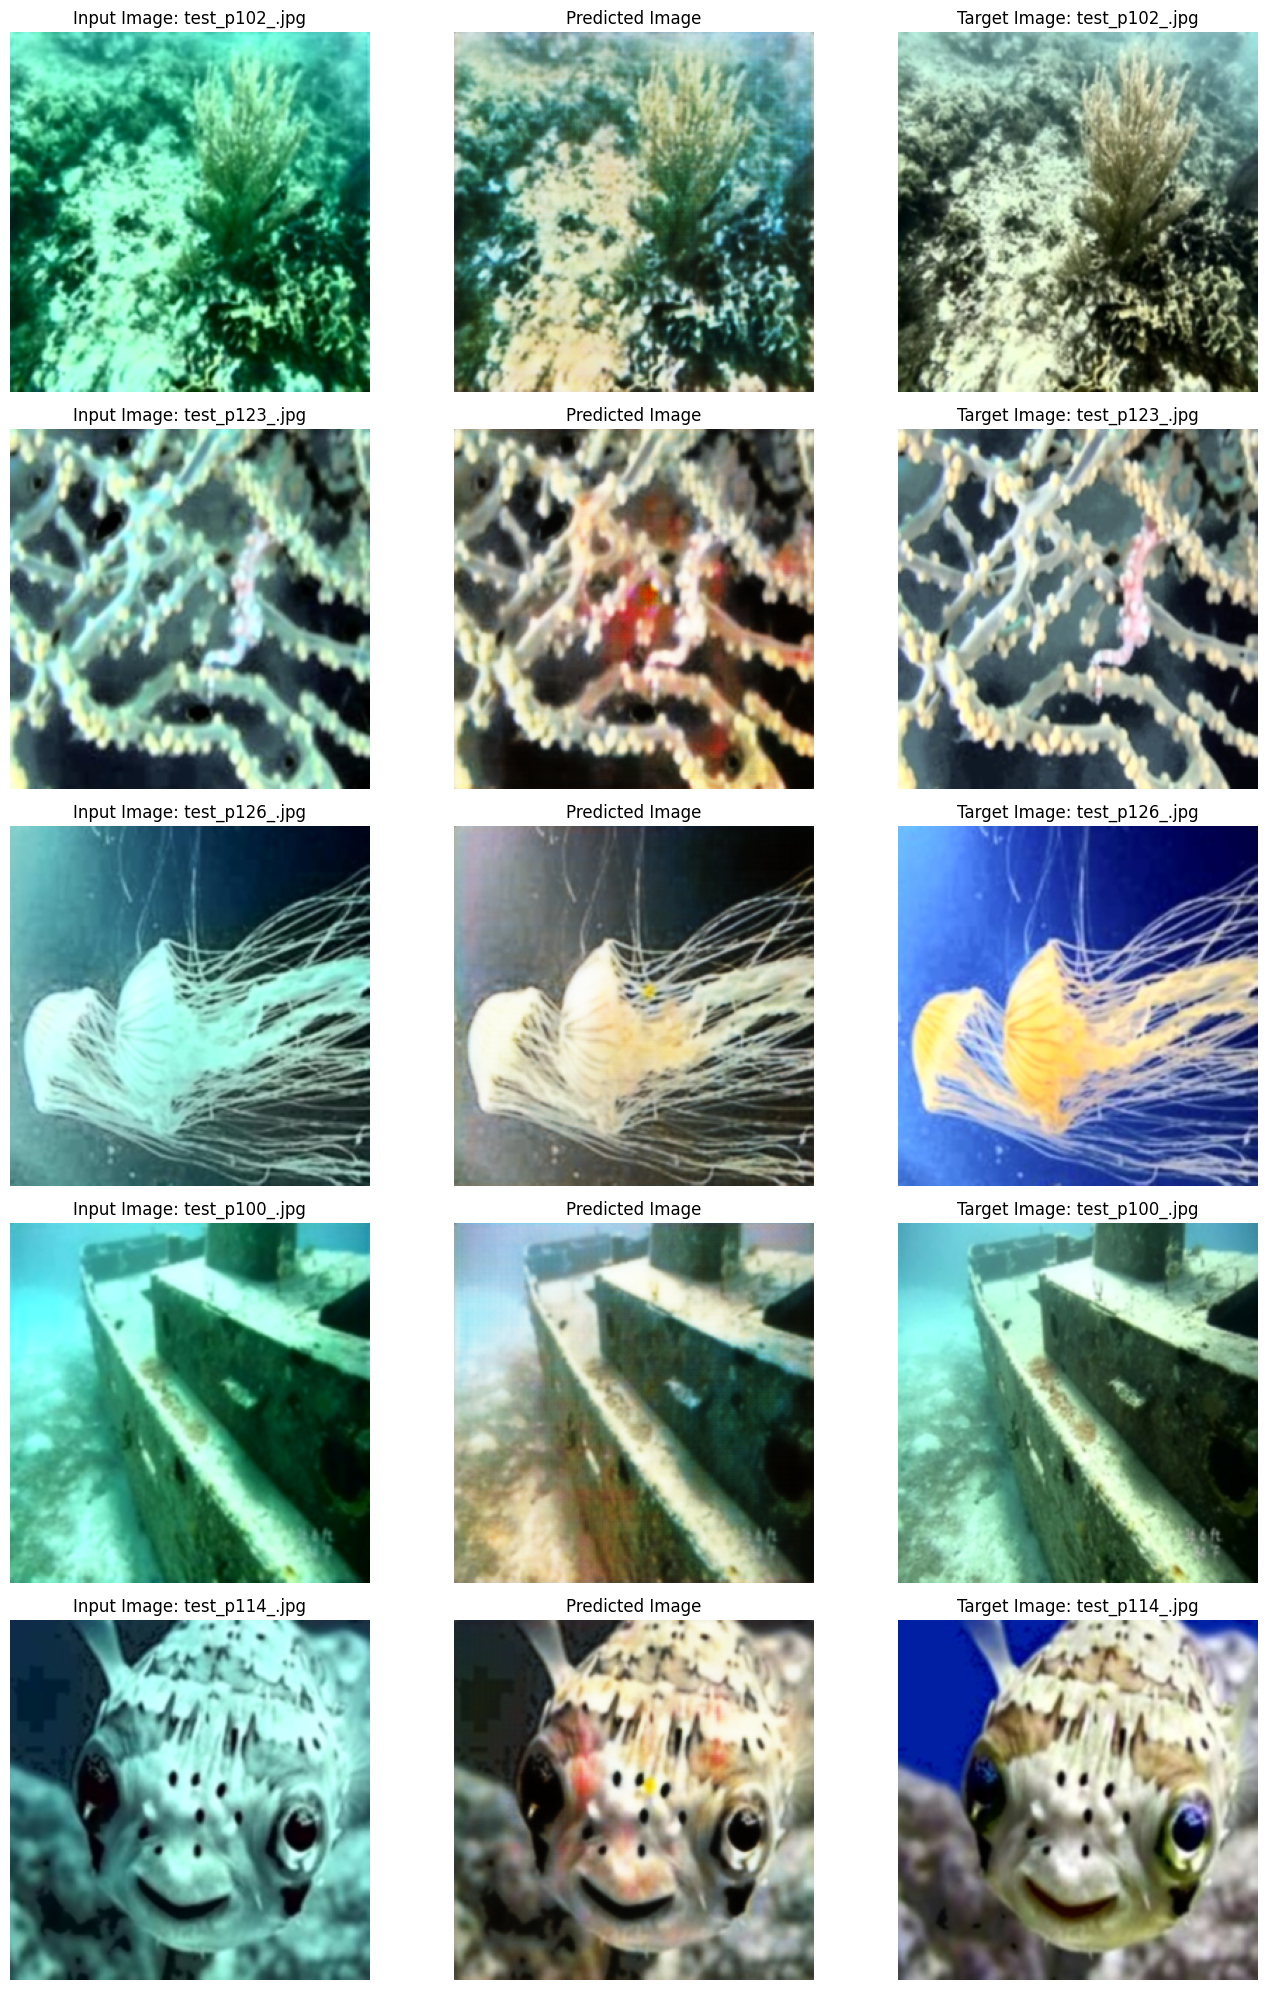

In [ ]:
# Define your input and target images directories
input_images_dir = "/content/drive/MyDrive/ImageEnhancement/Data/test/input"
target_images_dir = "/content/drive/MyDrive/ImageEnhancement/Data/test/target"
 # High-quality images

# Get the filenames for the images (sorted to match X_test and Y_test order)
input_filenames = sorted(os.listdir(input_images_dir))
target_filenames = sorted(os.listdir(target_images_dir))

# Filter out non-image files if needed (you can add more extensions if required)
input_filenames = [filename for filename in input_filenames if filename.endswith(('.jpg', '.png', '.jpeg'))]
target_filenames = [filename for filename in target_filenames if filename.endswith(('.jpg', '.png', '.jpeg'))]

def test_multiple_images(generator, X_test, Y_test, input_filenames, target_filenames, num_samples=5):
    """
    Tests the generator on multiple images and visualizes them along with filenames.
    Args:
    - generator: Trained GAN generator model
    - X_test: Input test images (low-quality)
    - Y_test: Ground truth high-quality images
    - input_filenames: List of filenames for input (low-quality) images
    - target_filenames: List of filenames for target (high-quality) images
    - num_samples: Number of images to visualize
    """
    indices = np.random.choice(len(X_test), num_samples, replace=False)

    fig, axes = plt.subplots(num_samples, 3, figsize=(14, 4 * num_samples))

    for i, idx in enumerate(indices):
        input_img = X_test[idx]
        ground_truth = Y_test[idx]
        input_filename = input_filenames[idx]
        target_filename = target_filenames[idx]

        # Expand dimension for batch prediction
        if len(input_img.shape) == 3:
            input_img = np.expand_dims(input_img, axis=0)

        predicted_img = generator.predict(input_img)[0]

        # Convert from [-1, 1] to [0, 1]
        input_img = np.clip((input_img[0] + 1) / 2, 0, 1)
        predicted_img = np.clip((predicted_img + 1) / 2, 0, 1)
        ground_truth = np.clip((ground_truth + 1) / 2, 0, 1)

        # Plot all 3 images
        axes[i, 0].imshow(input_img)
        axes[i, 0].set_title(f"Input Image: {input_filename}")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(predicted_img)
        axes[i, 1].set_title("Predicted Image")
        axes[i, 1].axis('off')

        axes[i, 2].imshow(ground_truth)
        axes[i, 2].set_title(f"Target Image: {target_filename}")
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Run the function with your test set
test_multiple_images(generator, X_test, Y_test, input_filenames, target_filenames, num_samples=5)


In [ ]:
def evaluate_model(generator, X_test, Y_test, num_samples=10):
    psnr_values = []
    ssim_values = []

    for i in range(num_samples):
        input_img = X_test[i]  # Input image
        gt_img = Y_test[i]     # Ground Truth

        # Generate prediction
        pred_img = generator.predict(np.expand_dims(input_img, axis=0))[0]

        # Convert to uint8 (0-255) for PSNR and SSIM
        gt_8bit = np.clip((gt_img * 127.5 + 127.5), 0, 255).astype(np.uint8)
        pred_8bit = np.clip((pred_img * 127.5 + 127.5), 0, 255).astype(np.uint8)

        # Ensure both images are the same shape before computing metrics
        if gt_8bit.shape != pred_8bit.shape:
            pred_8bit = cv2.resize(pred_8bit, (gt_8bit.shape[1], gt_8bit.shape[0]))

        # Compute PSNR
        psnr_value = cv2.PSNR(gt_8bit, pred_8bit)
        psnr_values.append(psnr_value)

        # Compute SSIM with correct win_size
        min_dim = min(gt_8bit.shape[:2])  # Find the smallest dimension (H or W)
        win_size = min(7, min_dim)  # Ensure win_size is ≤ 7 and valid

        # Check if image is grayscale or color
        if len(gt_8bit.shape) == 3:  # Color image
            ssim_value = ssim(gt_8bit, pred_8bit, data_range=255, win_size=win_size, channel_axis=2)
        else:  # Grayscale image
            ssim_value = ssim(gt_8bit, pred_8bit, data_range=255, win_size=win_size)

        ssim_values.append(ssim_value)

        print(f"Sample {i+1}: PSNR = {psnr_value:.2f}, SSIM = {ssim_value:.4f}")

    # Compute averages
    avg_psnr = np.mean(psnr_values)
    avg_ssim = np.mean(ssim_values)

    print("\n✅ Model Evaluation Completed!")
    print(f"📊 Average PSNR: {avg_psnr:.2f}")
    print(f"📊 Average SSIM: {avg_ssim:.4f}")

    return avg_psnr, avg_ssim


In [ ]:
evaluate_model(generator, X_test, Y_test, num_samples=10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step
Sample 1: PSNR = 18.14, SSIM = 0.7936
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
Sample 2: PSNR = 20.51, SSIM = 0.8658
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step
Sample 3: PSNR = 18.36, SSIM = 0.8198
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step
Sample 4: PSNR = 22.22, SSIM = 0.8532
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step
Sample 5: PSNR = 10.91, SSIM = 0.6756
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step
Sample 6: PSNR = 23.54, SSIM = 0.8754
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
Sample 7: PSNR = 16.58, SSIM = 0.8089
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
Sample 8: PSNR = 22.70, SSIM = 0.8688
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
Sample 9: PSNR = 13.11, SSIM = 0.4295
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
Sample 10: PSNR = 18.12, SSIM = 0.8333

✅ Model Evaluation Completed!
📊 Average PSNR: 18.42
📊 Average SSIM: 0.7824


(np.float64(18.418502544859933), np.float64(0.78240081936302))